## Data Loading

Sumber dataset: [Hotel-Review Datasets](https://www.cs.cmu.edu/~jiweil/html/hotel-review.html)

Melakukan import library yang dibutuhkan dan memuat dataset yang akan digunakan.

In [1]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import LancasterStemmer
import seaborn as sns
import nltk
import string
import re
import seaborn as sns
from sklearn.utils import resample
from nltk.corpus import stopwords
from langdetect import detect
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from textblob import TextBlob
from IPython.display import clear_output

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
df_data = pd.read_csv('Data/data_2/review.csv')
df_data = df_data[['ratings_overall', 'title', 'text']]
df_data

,ratings_overall,title,text
0,5.0,"“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...
1,5.0,“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the..."
2,4.0,“Great Stay”,This is a great property in Midtown. We two di...
3,4.0,“Modern Convenience”,The Andaz is a nice hotel in a central locatio...
4,4.0,“Its the best of the Andaz Brand in the US....”,I have stayed at each of the US Andaz properti...
...,...,...,...
878556,4.0,“vil komme igen”,"Pænt hotel i et livligt miljø. Store værelser,..."
878557,4.0,“excellent”,"un excellent hotel 4 *, pour un prix raisonnab..."
878558,5.0,“Un hotel eccezionale”,"L'hotel, situato in una zona tranquilla e a du..."
878559,5.0,“Gerne wieder”,Sehr schön ausgestattetes Hotel in bester Lage...


## Exploratory Data Analysis

In [4]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878561 entries, 0 to 878560
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ratings_overall  878561 non-null  float64
 1   title            878561 non-null  object 
 2   text             878561 non-null  object 
dtypes: float64(1), object(2)
memory usage: 20.1+ MB


In [5]:
print('duplicated\t', df_data.duplicated().sum())
print(df_data.isnull().sum())

duplicated	 803
ratings_overall    0
title              0
text               0
dtype: int64


In [6]:
df_data.describe()

,ratings_overall
count,878561.000000
mean,3.936228
std,1.165074
min,0.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [7]:
def language_detection_single(text):
    try:
        return detect(text)
    except:
        return 'other'
    
def language_detection(texts, n_jobs=1):
    with ThreadPoolExecutor(max_workers=n_jobs) as executor:
        languages = list(executor.map(language_detection_single, texts))
    return languages

In [8]:
df_data['language'] = language_detection(df_data['text'], n_jobs=6)
df_data.value_counts('language')

language
en       761527
de        26943
fr        24909
it        20255
es        14002
other      9881
ja         5992
pt         4513
nl         3263
sv         2967
da         1664
no         1389
zh-cn       523
ru          278
af          160
tr          110
pl           51
ko           43
el           20
ca           20
th           14
zh-tw         9
so            6
vi            5
ro            4
id            4
sl            2
sq            2
et            1
ar            1
fi            1
tl            1
hu            1
Name: count, dtype: int64

In [9]:
df_data = df_data[df_data['language'] == 'en']

In [10]:
analyzer = SentimentIntensityAnalyzer()

In [11]:
def sentiment_analyzer_scores_single(sentence):
    score = analyzer.polarity_scores(sentence)
    if score['compound'] >= 0.5:
        return 'positive'
    elif score['compound'] <= -0.5:
        return 'negative'
    else:
        return 'neutral'

def sentiment_analyzer_scores(sentences, n_jobs=1):
    with ThreadPoolExecutor(max_workers=n_jobs) as executor:
        sentiments = list(executor.map(sentiment_analyzer_scores_single, sentences))
    return sentiments

In [12]:
df_data['label'] = sentiment_analyzer_scores(df_data['text'], n_jobs=6)

C:\Users\ACER\AppData\Local\Temp\ipykernel_3372\2072383767.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data['label'] = sentiment_analyzer_scores(df_data['text'], n_jobs=6)


<Axes: xlabel='label'>

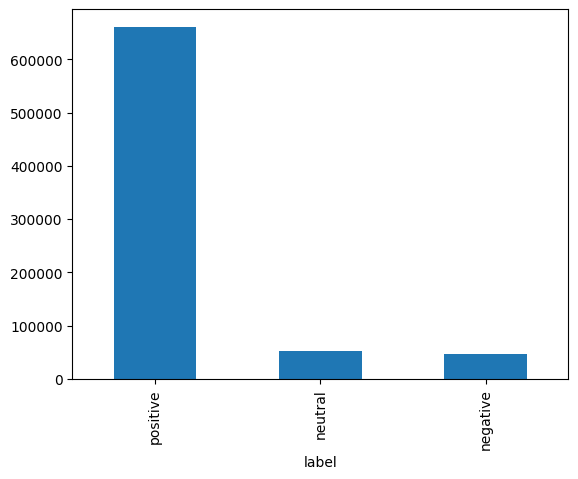

In [13]:
df_data['label'].value_counts().plot(kind='bar')

In [14]:
df_data['label'].value_counts()

label
positive    661193
neutral      52966
negative     47368
Name: count, dtype: int64

## Data Preprocessing

### Remove Duplicate Data

In [15]:
df_data.drop_duplicates(inplace=True)
df_data.duplicated().sum()

C:\Users\ACER\AppData\Local\Temp\ipykernel_3372\4057778840.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data.drop_duplicates(inplace=True)


0

### Downsample Data

In [16]:
df_new = pd.DataFrame()
target_count = 48105

for rating, group in df_data.groupby('label'):
    if len(group) > target_count:
        ratings_new = resample(group, replace=False, n_samples=target_count, random_state=42)
    else:
        ratings_new = group
    df_new = pd.concat([df_new, ratings_new])

df_data = df_new.reset_index(drop=True)
df_data['label'].value_counts()

label
neutral     48105
positive    48105
negative    47360
Name: count, dtype: int64

In [17]:
df_data['text'] = df_data['title'] + ' ' + df_data['text']
df_data = df_data[['text', 'label']]

### Remove Special Character and Additional Cleaning

In [18]:
def remove_punctuation(text):
    text = ''.join([char if char not in string.punctuation else ' ' for char in text]).lower()
    return text

In [19]:
def additional_cleaning(text):
    replacements = {
        'n t': 'not',
        'nt': 'not',
        'didn t': 'did not',
        'didn': 'did not',
        'don t': 'do not',
        'don': 'do not',
        'doesn t': 'does not',
        'doesn': 'does not',
        'hasn t': 'has not',
        'hasn': 'has not',
        'haven t': 'have not',
        'haven': 'have not',
        'hadn t': 'had not',
        'hadn': 'had not',
        'won t': 'will not',
        'won': 'will not',
        'wouldn t': 'would not',
        'wouldn': 'would not',
        'can t': 'can not',
        'can': 'can not',
        'couldn t': 'could not',
        'couldn': 'could not',
        'shouldn t': 'should not',
        'shouldn': 'should not',
        'aren t': 'are not',
        'aren': 'are not',
        'ain t': 'am not',
        'ain': 'am not',
        'isn t': 'is not',
        'isn': 'is not',
        'wasn t': 'was not',
        'wasn': 'was not',
        'were t': 'were not',
        'were': 'were not',
        'weren t': 'were not',
        'weren': 'were not',
        'what s': 'what is',
        'what': 'what is',
        'who s': 'who is',
        'who': 'who is',
        'where s': 'where is',
        'where': 'where is',
        'when s': 'when is',
        'when': 'when is',
        'why s': 'why is',
        'why': 'why is',
        'how s': 'how is',
        'how': 'how is',
        'll': 'will',
        've': 'have',
        're': 'are',
        'm': 'am',
        'em': 'them',
        'thats': 'that is',
        'that s': 'that is'
    }
    for old, new in replacements.items():
        text = re.sub(r'\b' + old + r'\b', new, text)

    text = re.sub(r'[^\x00-\x7F]+', '', text)

    return text

In [20]:
df_data['clean_punc'] = df_data['text'].apply(lambda x: remove_punctuation(x)).apply(lambda x: additional_cleaning(x))

### Word Correction

In [21]:
def word_correction_single(index, text):
    corrected_text = str(TextBlob(text).correct())
    print(f"{index} done.")
    clear_output(wait=True)
    return corrected_text

def word_correction(texts, n_jobs=1):
    with ThreadPoolExecutor(max_workers=n_jobs) as executor:
        corrected_texts = list(executor.map(word_correction_single, range(len(texts)), texts))
    return corrected_texts

In [22]:
df_data['clean_punc'] = word_correction(df_data['clean_punc'], n_jobs=6)

143566 done.


### Stopwords Removal


In [23]:
stopwords_list = stopwords.words('english')
def remove_stopwords_single(text):
    token_words = text.split()
    filtered_words = []
    for word in token_words:
        if word not in stopwords_list:
            filtered_words.append(word)
    return ' '.join(filtered_words)

def remove_stopwords(texts, n_jobs=1):
    with ThreadPoolExecutor(max_workers=n_jobs) as executor:
        filtered_texts = list(executor.map(remove_stopwords_single, texts))
    return filtered_texts

In [24]:
df_data['clean_punc'] = remove_stopwords(df_data['clean_punc'], n_jobs=6)

### Lemmatization

In [25]:
nlp = spacy.load('en_core_web_lg')

In [26]:
def lemmatize_text(texts):
    lemmatized_texts = []
    for doc in nlp.pipe(texts, n_process=6,batch_size=1000):
        lemmatized_text = " ".join([token.lemma_ for token in doc])
        lemmatized_texts.append(lemmatized_text)
    return lemmatized_texts

In [27]:
df_data['lemmatized_review'] = lemmatize_text(df_data['clean_punc'])

### Remove Word-Number Combination

In [28]:
def remove_token_with_word_and_number(text):
    words = text.split()
    filtered_words = []
    for word in words:
        if not any(char.isdigit() for char in word):
            filtered_words.append(word)
    return ' '.join(filtered_words)


In [29]:
df_data['number_review'] = df_data['lemmatized_review'].apply(lambda x: remove_token_with_word_and_number(x))

### Named Entity Recognition

In [30]:
def perform_ner(texts):
    replaced_texts = []
    for doc in nlp.pipe(texts, n_process=6, batch_size=1000):
        replaced_text = []
        for token in doc:
            if token.ent_type_:
                replaced_text.append(token.ent_type_)
            else:
                replaced_text.append(token.text)
        replaced_texts.append(' '.join(replaced_text))
    
    return replaced_texts

def remove_ner(texts):
    cleaned_texts = []
    for doc in nlp.pipe(texts, n_process=6, batch_size=1000):
        cleaned_text = []
        for token in doc:
            if not token.ent_type_:
                cleaned_text.append(token.text)
        cleaned_texts.append(' '.join(cleaned_text))
    
    return cleaned_texts

In [31]:
df_data['ner_review'] = remove_ner(df_data['number_review'])

In [32]:
print('Original Review:\t', df_data['text'][0])
print('Lemmatized Review:\t', df_data['lemmatized_review'][0])
print('Token Number Review:\t', df_data['number_review'][0])
print('Name Entity R Review:\t', df_data['ner_review'][0])

Original Review:	 “Don't believe the hype” One thing that I usually enjoy about Marriott is that I usually always enjoy my stay, whether it's in a Category 2 joint or a Category 4 palace. After reading the rave reviews about this particular place, I was looking forward to my business trip to Houston.
 The location is great; not even 10 minutes from the airport. When I arrived late at night and got to my room, I pulled the covers back and saw a huge silverfish crawling on one of the pillows. Ok, not comforting, but not a deal breaker, either. Bugs find their way into even the cleanest hotel. 
The next night, I went to the gym only to find that the floor was damp from a water leak and the place reeked of mildew. At dinner, I went to get a salad and the lettuce looked like it had been sitting in the sun all day. I was starting to see a pattern. The next day, breakfast consisted of eggs mixed with cut up hot dogs from the night before. Yuck. My mom used to do that trick with leftovers when

In [33]:
df_data.head()

,text,label,clean_punc,lemmatized_review,number_review,ner_review
0,“Don't believe the hype” One thing that I usua...,negative,believe hope one thing usually enjoy merritt u...,believe hope one thing usually enjoy merritt u...,believe hope one thing usually enjoy merritt u...,believe hope thing usually enjoy merritt usual...
1,“We got bed bugs from this hotel” We stayed 3 ...,negative,got bed bags hotel stayed 3 nights location go...,get bed bag hotel stay 3 night location good o...,get bed bag hotel stay night location good one...,get bed bag hotel stay night location good que...
2,“Just Ok” Stayed one night with family in July...,negative,ok stayed one night family july 2012 four poin...,ok stay one night family july 2012 four point ...,ok stay one night family july four point easy ...,ok stay family point easy get we dirty conveni...
3,“Charge for business facilities” The service w...,negative,charge business facilities service terrible ro...,charge business facility service terrible room...,charge business facility service terrible room...,charge business facility service terrible room...
4,“Hated my stay at Homestead Suites” Do NOT sta...,negative,hated stay homestead suites stay blotched rese...,hate stay homestead suite stay blotched reserv...,hate stay homestead suite stay blotched reserv...,hate stay homestead suite stay blotched reserv...


In [34]:
df_clean = df_data[['ner_review', 'label']]
df_clean.columns = ['text', 'label']

In [35]:
df_clean.to_csv('Data/data_2/clean_review_small.csv', index=False)